In [ ]:
import time
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from sklearn.manifold import TSNE
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
COLORS = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#D55E00", "#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)

### AlexNet and ResNet

In [ ]:
alexnet = torchvision.models.alexnet(weights=None)
resnet18 = torchvision.models.resnet18(weights=None)

Using ResNet18 instead of ResNet50 because ResNet50 is too heavy for my laptop to handle and it is taking a lot of time to train it.

In [ ]:
print("AlexNet")
_ = summary(alexnet, (3, 64, 64))

AlexNet
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 15, 15]          23,296
|    └─ReLU: 2-2                         [-1, 64, 15, 15]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 192, 7, 7]           307,392
|    └─ReLU: 2-5                         [-1, 192, 7, 7]           --
|    └─MaxPool2d: 2-6                    [-1, 192, 3, 3]           --
|    └─Conv2d: 2-7                       [-1, 384, 3, 3]           663,936
|    └─ReLU: 2-8                         [-1, 384, 3, 3]           --
|    └─Conv2d: 2-9                       [-1, 256, 3, 3]           884,992
|    └─ReLU: 2-10                        [-1, 256, 3, 3]           --
|    └─Conv2d: 2-11                      [-1, 256, 3, 3]           590,080
|    └─ReLU: 2-12                        [-1, 256, 3,

In [ ]:
print("Resnet50")
_ = summary(resnet18, (3, 32, 32))

Resnet50
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]       

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
# Take a subset of the dataset to speed up training for this assignment (500 images per class)
subset_indices = []
for i in range(10):
    subset_indices.append(np.where(np.array(dataset.targets) == i)[0][:500])
subset_indices = np.concatenate(subset_indices)
datasubset = torch.utils.data.Subset(dataset, subset_indices)

In [ ]:
total_size = len(datasubset)
print("Total size of dataset:", total_size)
train_size, validation_size = int(0.7 * total_size), int(0.1 * total_size)
test_size = total_size - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(datasubset, [train_size, validation_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

Total size of dataset: 5000


In [ ]:
def trainLoop(model, trainloader, optimizer):
    """
    Trains the model.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    trainloader : torch.utils.data.DataLoader
        The training data.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    device : str
        The device to use for training.

    Returns
    -------
    model : nn.Module
        The trained model.
    train_loss : float
        The training loss.
    train_accuracy : float
        The training accuracy.
    """

    model.train()
    train_loss = 0.0
    train_accuracy = 0
    train_examples = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(images)
        train_examples += len(images)

        prediction = torch.argmax(output, dim=1)
        train_accuracy += torch.sum(prediction == labels).item()

    train_loss /= train_examples
    train_accuracy /= train_examples

    return model, train_loss, train_accuracy

In [ ]:
def valLoop(model, testloader):
    """
    Validates the model.

    Parameters
    ----------
    model : nn.Module
        The model to validate.
    testloader : torch.utils.data.DataLoader
        The validation data.

    Returns
    -------
    val_loss : float
        The validation loss.
    val_accuracy : float
        The validation accuracy.
    """

    model.eval()
    val_loss = 0.0
    val_accuracy = 0
    val_examples = 0

    with torch.no_grad():
        for images, labels in testloader:
            output = model(images)
            loss = F.cross_entropy(output, labels)

            val_loss += loss.item() * len(images)
            val_examples += len(images)

            prediction = torch.argmax(output, dim=1)
            val_accuracy += torch.sum(prediction == labels).item()

    val_loss /= val_examples
    val_accuracy /= val_examples

    return val_loss, val_accuracy

### Train Model

In [ ]:
def trainModel(model, dataloader, epochs, optimizer, patience=10):
    """
    Trains the model.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    dataloader : tuple of torch.utils.data.DataLoader
        The training, validation and test data.
    epochs : int
        The number of epochs to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    patience : int
        The number of epochs to wait for validation loss to improve.

    Returns
    -------
    model : nn.Module
        The trained model.
    train_metrics : tuple
        tuple of train_losses, train_accuracies
    val_metrics : tuple
        tuple of val_losses, val_accuracies
    test_metrics : tuple
        tuple of test_losses, test_accuracies
    """

    trainloader, valloader, testloader = dataloader
    best_val_loss = np.inf
    best_model = model
    patience_param = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        model, train_loss, train_accuracy = trainLoop(model, trainloader, optimizer)
        model.eval()
        val_loss, val_accuracy = valLoop(model, valloader)
        print(f"Epoch {epoch + 1} | Training loss: {train_loss:.4f} | Training accuracy: {train_accuracy:.4f} | Validation loss: {val_loss:.4f} | Validation accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
            patience_param = 0
        else:
            patience_param += 1
            if patience_param >= patience:
                print(f"Early stopping. Epoch: {epoch + 1}")
                break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    test_loss, test_accuracy = valLoop(best_model, testloader)
    print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f}")

    return best_model, (train_losses, train_accuracies), (val_losses, val_accuracies), (test_loss, test_accuracy)

### AlexNet

In [ ]:
optimizer = torch.optim.Adam(alexnet.parameters(), lr=2e-4, weight_decay=5e-4)
alexnet, train_metrics, val_metrics, test_metrics = trainModel(alexnet, (trainloader, validationloader, testloader), 50, optimizer)

/Users/divyanshubhatt/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 | Training loss: 6.6151 | Training accuracy: 0.0714 | Validation loss: 2.9159 | Validation accuracy: 0.0920
Epoch 2 | Training loss: 3.4441 | Training accuracy: 0.1009 | Validation loss: 4.7242 | Validation accuracy: 0.1180
Epoch 3 | Training loss: 3.8128 | Training accuracy: 0.1006 | Validation loss: 3.5665 | Validation accuracy: 0.0920
Epoch 4 | Training loss: 3.6286 | Training accuracy: 0.1034 | Validation loss: 3.2846 | Validation accuracy: 0.0920
Epoch 5 | Training loss: 3.2938 | Training accuracy: 0.1034 | Validation loss: 2.9560 | Validation accuracy: 0.0920
Epoch 6 | Training loss: 2.8058 | Training accuracy: 0.1037 | Validation loss: 2.7452 | Validation accuracy: 0.1000
Epoch 7 | Training loss: 2.6569 | Training accuracy: 0.0943 | Validation loss: 2.5866 | Validation accuracy: 0.0920
Epoch 8 | Training loss: 2.5468 | Training accuracy: 0.1043 | Validation loss: 2.4498 | Validation accuracy: 0.0920
Epoch 9 | Training loss: 2.4034 | Training accuracy: 0.0949 | Validation

In [ ]:
# Save alexnet Model
torch.save(alexnet.state_dict(), "alexnet.pt")

In [ ]:
alexnet = torchvision.models.alexnet(weights=None)
alexnet.load_state_dict(torch.load("alexnet.pt"))

<All keys matched successfully>

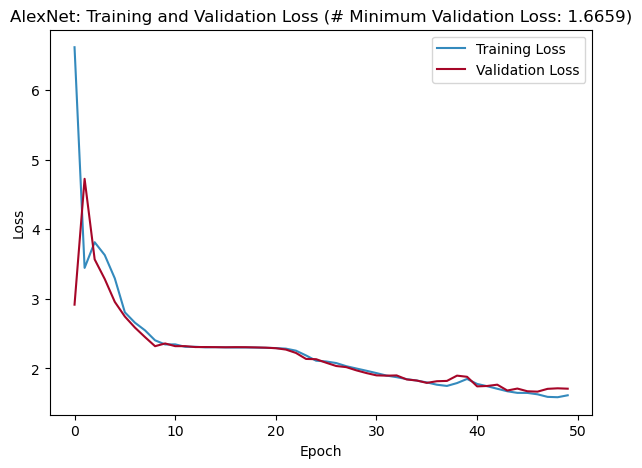

In [ ]:
# Plotting the Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(train_metrics[0], label="Training Loss")
plt.plot(val_metrics[0], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"AlexNet: Training and Validation Loss (# Minimum Validation Loss: {np.min(val_metrics[0]):.4f})")
plt.legend()
plt.show()

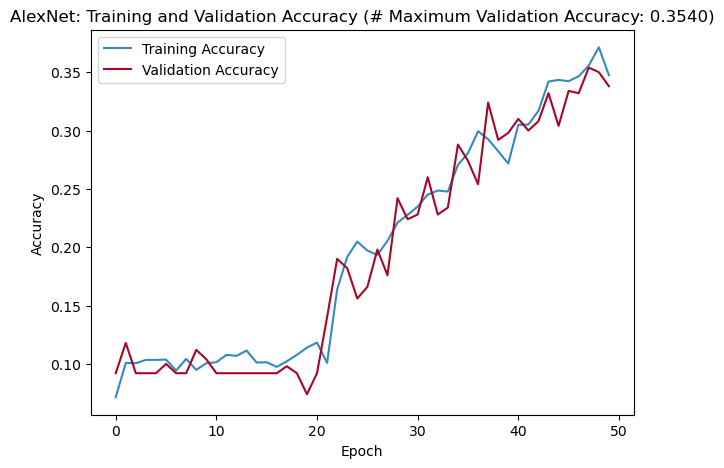

In [ ]:
# Plotting the Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(train_metrics[1], label="Training Accuracy")
plt.plot(val_metrics[1], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet: Training and Validation Accuracy (# Maximum Validation Accuracy: {np.max(val_metrics[1]):.4f})")
plt.legend()
plt.show()

In [ ]:
print(f"Loss and Accuracy on Test Set of AlexNet are {test_metrics[0]:.4f} and {test_metrics[1]:.4f} respectively.")

Loss and Accuracy on Test Set of AlexNet are 1.7141 and 0.3300 respectively.


In [ ]:
bottleneck_features, targets = [], []
with torch.no_grad():
    for images, labels in testloader:
        # Get the bottleneck features
        bottleneck = alexnet.features(images)
        bottleneck = alexnet.avgpool(bottleneck)
        bottleneck = torch.flatten(bottleneck, 1)
        bottleneck_features.append(bottleneck)
        targets.append(labels)
bottleneck_features = torch.cat(bottleneck_features)
targets = torch.cat(targets)

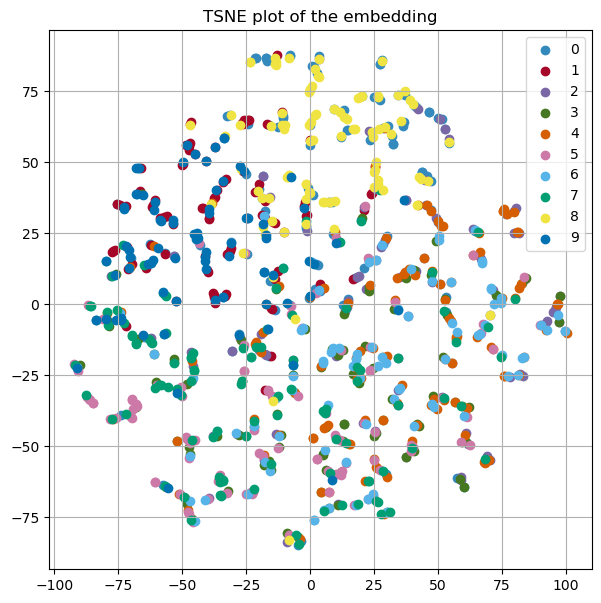

In [ ]:
# Plotting the t-SNE plot
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(bottleneck_features)

plt.figure(figsize=(7, 7))
for i in range(10):
    index = np.where(np.array(targets) == i)[0]
    plt.scatter(embeddings[index, 0], embeddings[index, 1], label=str(i))

plt.title("TSNE plot of the embedding")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
activation_maps1, activation_maps2 = [], []
with torch.no_grad():
    for idx, (images, _) in enumerate(testloader):
        image = images[:1]
        activation_map = alexnet.features(image)
        activation_maps1.append(activation_map)
        activation_map = alexnet.avgpool(activation_map)
        activation_maps2.append(activation_map)

/Users/divyanshubhatt/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Activation Map 1: tensor([[0.]])
Activation Map 2: tensor([[0.0371]])
Activation Map 3: tensor([[0.0705]])
Activation Map 4: tensor([[0.0441]])
Activation Map 5: tensor([[0.0814]])
Activation Map 6: tensor([[0.0814]])


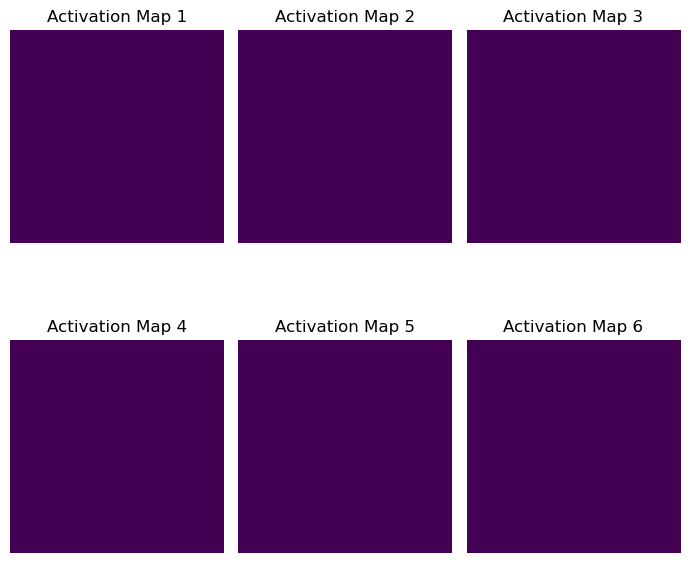

In [ ]:
# Plot random activation maps
plt.figure(figsize=(7, 7))
for i in range(6):
    idx = random.randint(0, 256)
    plt.subplot(2, 3, i + 1)
    plt.imshow(activation_maps1[0][0][idx])
    plt.title(f"Activation Map {i + 1}")
    plt.axis('off')
    print(f"Activation Map {i + 1}: {activation_maps1[0][0][idx]}")
plt.tight_layout()
plt.show()

Activation Map 1: tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
Activation Map 2: tensor([[0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
        [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
        [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
        [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
        [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769],
        [0.0769, 0.0769, 0.0769, 0.0769, 0.0769, 0.0769]])
Activation Map 3: tensor([[0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416],
        [0.0416, 0.0416, 0.0416, 0.0416, 0.0416, 0.0416]])
Activation Map 4: tensor([[0.1078, 0.1078, 

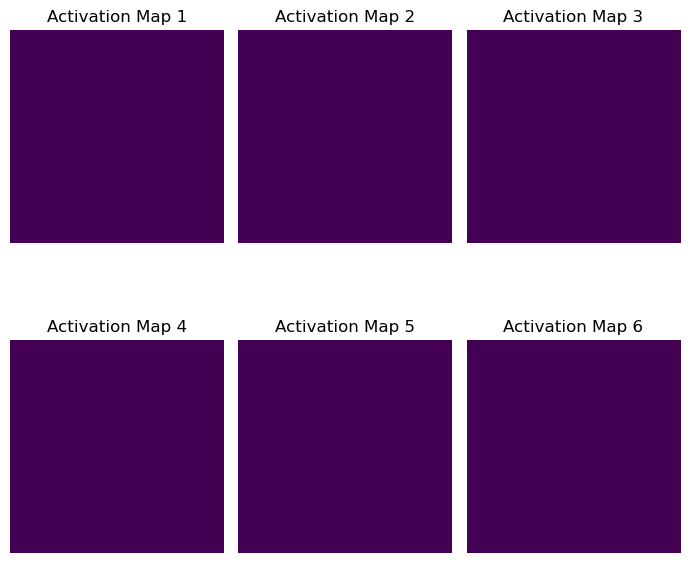

In [ ]:
# Plot random activation maps
plt.figure(figsize=(7, 7))
for i in range(6):
    idx = random.randint(0, 256)
    plt.subplot(2, 3, i + 1)
    plt.imshow(activation_maps2[0][0][idx])
    plt.title(f"Activation Map {i + 1}")
    plt.axis('off')
    print(f"Activation Map {i + 1}: {activation_maps2[0][0][idx]}")
plt.tight_layout()
plt.show()

### ResNet

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((64,64)),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
# Take a subset of the dataset to speed up training for this assignment (500 images per class)
subset_indices = []
for i in range(10):
    subset_indices.append(np.where(np.array(dataset.targets) == i)[0][:500])
subset_indices = np.concatenate(subset_indices)
datasubset = torch.utils.data.Subset(dataset, subset_indices)

In [ ]:
total_size = len(datasubset)
print("Total size of the dataset:", total_size)
train_size, validation_size = int(0.7 * total_size), int(0.1 * total_size)
test_size = total_size - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(datasubset, [train_size, validation_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

Total size of the dataset: 5000


In [ ]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=2e-4, weight_decay=5e-4)
resnet18, train_metrics, val_metrics, test_metrics = trainModel(resnet18, (trainloader, validationloader, testloader), 20, optimizer)

Epoch 1 | Training loss: 7.1764 | Training accuracy: 0.0071 | Validation loss: 6.8450 | Validation accuracy: 0.0040
Epoch 2 | Training loss: 5.1378 | Training accuracy: 0.3129 | Validation loss: 6.5715 | Validation accuracy: 0.1120
Epoch 3 | Training loss: 3.5623 | Training accuracy: 0.4649 | Validation loss: 6.0194 | Validation accuracy: 0.1220
Epoch 4 | Training loss: 2.4257 | Training accuracy: 0.5406 | Validation loss: 5.3906 | Validation accuracy: 0.1360
Epoch 5 | Training loss: 1.6006 | Training accuracy: 0.6666 | Validation loss: 4.8791 | Validation accuracy: 0.1500
Epoch 6 | Training loss: 1.0073 | Training accuracy: 0.7871 | Validation loss: 4.4230 | Validation accuracy: 0.1600
Epoch 7 | Training loss: 0.5877 | Training accuracy: 0.8866 | Validation loss: 3.9210 | Validation accuracy: 0.2120
Epoch 8 | Training loss: 0.3181 | Training accuracy: 0.9557 | Validation loss: 3.4544 | Validation accuracy: 0.2260
Epoch 9 | Training loss: 0.1591 | Training accuracy: 0.9831 | Validation

In [ ]:
torch.save(resnet18.state_dict(), "resnet18.pt")

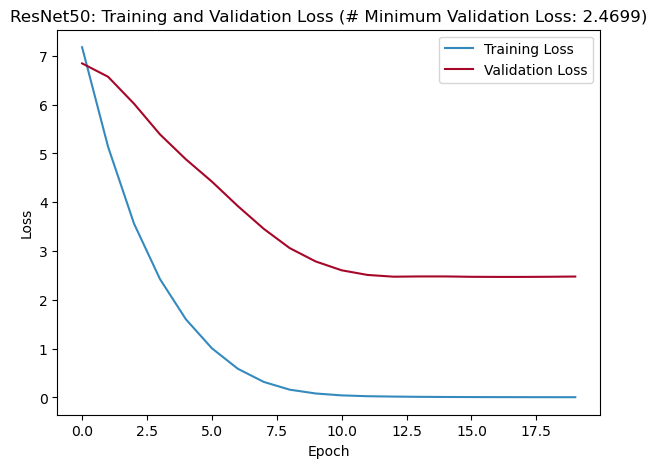

In [ ]:
# Plotting the Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(train_metrics[0], label="Training Loss")
plt.plot(val_metrics[0], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"ResNet50: Training and Validation Loss (# Minimum Validation Loss: {np.min(val_metrics[0]):.4f})")
plt.legend()
plt.show()

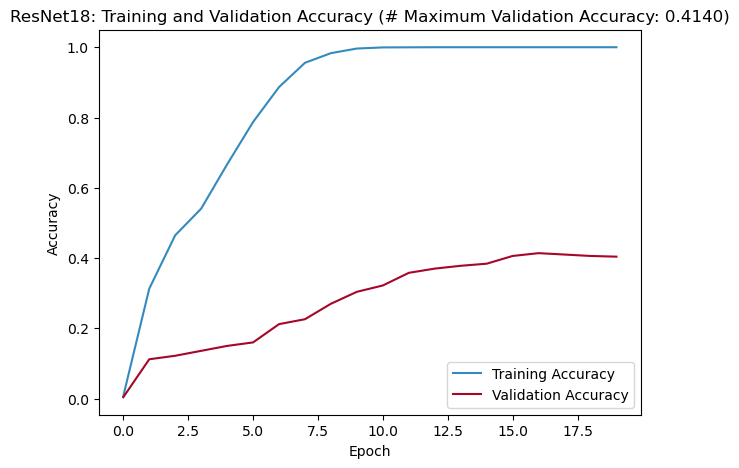

In [ ]:
# Plotting the Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(train_metrics[1], label="Training Accuracy")
plt.plot(val_metrics[1], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"ResNet18: Training and Validation Accuracy (# Maximum Validation Accuracy: {np.max(val_metrics[1]):.4f})")
plt.legend()
plt.show()

In [ ]:
print(f"Loss and Accuracy on Test Set of ResNet50 are {test_metrics[0]:.4f} and {test_metrics[1]:.4f} respectively.")

Loss and Accuracy on Test Set of ResNet50 are 2.4254 and 0.3960 respectively.


In [ ]:
bottleneck_features, targets = [], []
with torch.no_grad():
    for images, labels in testloader:
        # Get the bottleneck features
        bottleneck = resnet18.conv1(images)
        bottleneck = resnet18.bn1(bottleneck)
        bottleneck = resnet18.relu(bottleneck)
        bottleneck = resnet18.maxpool(bottleneck)
        bottleneck = resnet18.layer1(bottleneck)
        bottleneck = resnet18.layer2(bottleneck)
        bottleneck = resnet18.layer3(bottleneck)
        bottleneck = resnet18.layer4(bottleneck)
        bottleneck = resnet18.avgpool(bottleneck)
        bottleneck = torch.flatten(bottleneck, 1)
        bottleneck_features.append(bottleneck)
        targets.append(labels)

bottleneck_features = torch.cat(bottleneck_features)
targets = torch.cat(targets)

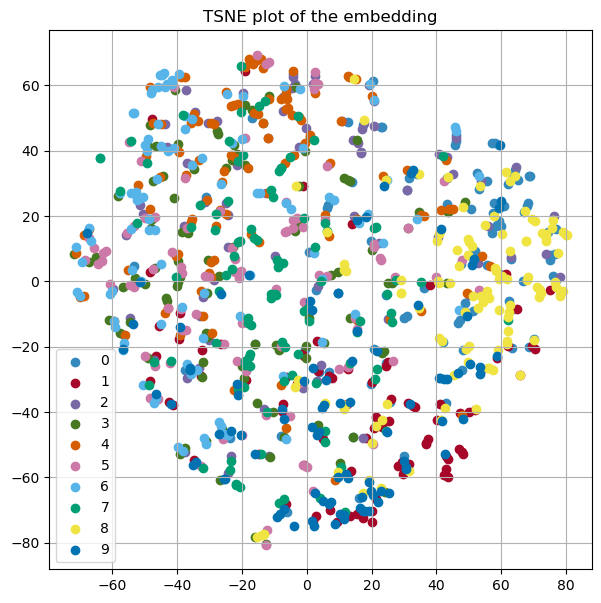

In [ ]:
# Plotting the t-SNE plot
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(bottleneck_features)

plt.figure(figsize=(7, 7))
for i in range(10):
    index = np.where(np.array(targets) == i)[0]
    plt.scatter(embeddings[index, 0], embeddings[index, 1], label=str(i))

plt.title("TSNE plot of the embedding")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
activation_maps1, activation_maps2, activation_maps3 = [], [], []
with torch.no_grad():
    for idx, (images, _) in enumerate(testloader):
        image = images[:1]
        activation_map = resnet18.conv1(image)
        activation_maps1.append(activation_map)
        activation_map = resnet18.bn1(activation_map)
        activation_map = resnet18.relu(activation_map)
        activation_map = resnet18.maxpool(activation_map)
        activation_map = resnet18.layer1(activation_map)
        activation_map = resnet18.layer2(activation_map)
        activation_maps2.append(activation_map)
        activation_map = resnet18.layer3(activation_map)
        activation_map = resnet18.layer4(activation_map)
        activation_maps3.append(activation_map)

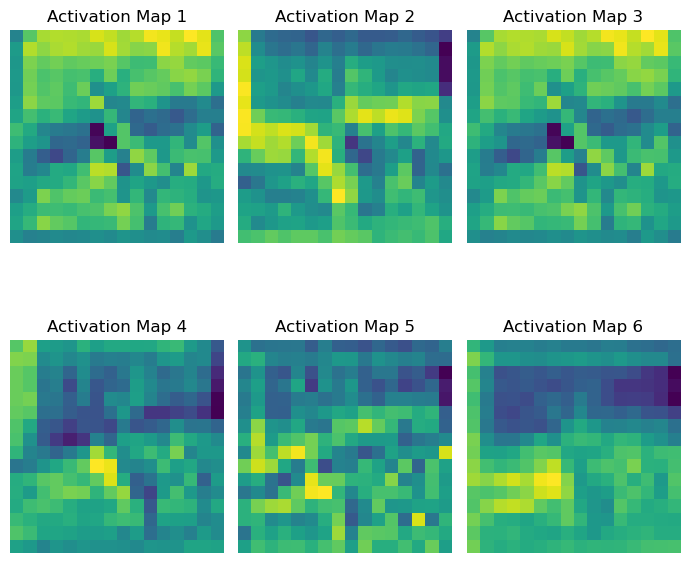

In [ ]:
# Plot random activation maps
plt.figure(figsize=(7, 7))
for i in range(6):
    idx = random.randint(0, 63)
    plt.subplot(2, 3, i + 1)
    plt.imshow(activation_maps1[0][0][idx])
    plt.title(f"Activation Map {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

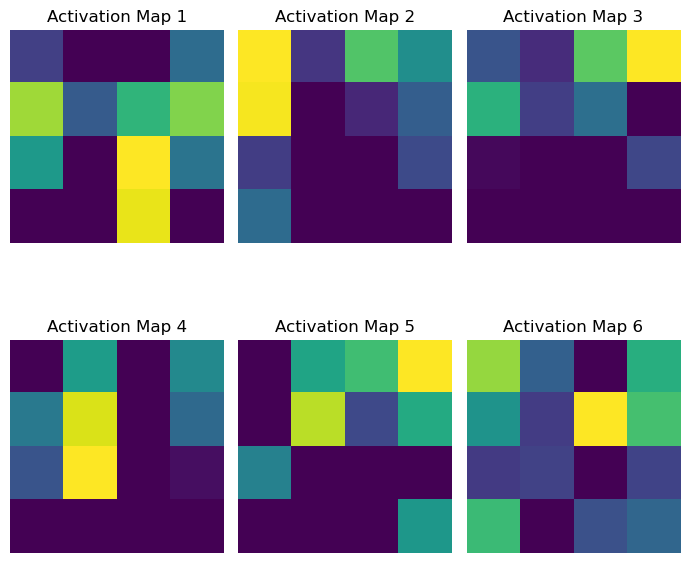

In [ ]:
# Plot random activation maps
plt.figure(figsize=(7, 7))
for i in range(6):
    idx = random.randint(0, 63)
    plt.subplot(2, 3, i + 1)
    plt.imshow(activation_maps2[0][0][idx])
    plt.title(f"Activation Map {i + 1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Activation Map 1: tensor([[1.0000]])
Activation Map 2: tensor([[1.5318]])
Activation Map 3: tensor([[0.]])
Activation Map 4: tensor([[0.]])
Activation Map 5: tensor([[3.0776]])
Activation Map 6: tensor([[1.6613]])


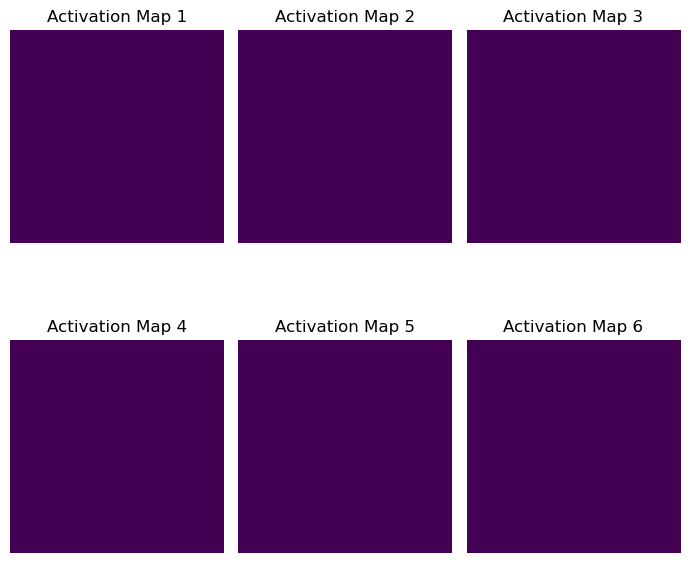

In [ ]:
# Plot random activation maps
plt.figure(figsize=(7, 7))
for i in range(6):
    idx = random.randint(0, 63)
    plt.subplot(2, 3, i + 1)
    plt.imshow(activation_maps3[0][0][idx])
    plt.title(f"Activation Map {i + 1}")
    plt.axis('off')
    print(f"Activation Map {i + 1}: {activation_maps3[0][0][idx]}")
plt.tight_layout()
plt.show()

Even though the number of parameters are less in ResNet18, it is taking more time to train than AlexNet. This is because of the deeper architecture of ResNet18 and more Convolutional layers in it as compared to AlexNet (Convolution Layers generally takes less parameters than Fully Connected Layers). ResNet is  performing better than AlexNet in terms of accuracy.

The choice of the network to use is subjective to the application. If the application is time critical, then AlexNet is a better choice. If the application is accuracy critical, then ResNet is a better choice.

### Replicating RNN code

In [ ]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
def letterToIndex(letter, all_letters):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter, n_letters):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line, n_letters, all_letters):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter, all_letters)] = 1
    return tensor

In [ ]:
def categoryFromOutput(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [ ]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(all_categories, all_letters, n_letters):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line, n_letters, all_letters)

    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample(all_categories, all_letters, n_letters)
    print('category =', category, '/ line =', line)

category = Scottish / line = Mclean
category = Korean / line = Rim
category = Japanese / line = Isoda
category = Russian / line = Voronihin
category = Polish / line = Sokolofsky
category = Polish / line = Lis
category = English / line = Tong
category = Vietnamese / line = Truong
category = Scottish / line = Jackson
category = English / line = Gleave


In [ ]:
def train(model, category_tensor, line_tensor, learning_rate = 0.005):
    hidden = model.initHidden()

    model.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = F.nll_loss(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def trainModel(model, all_categories, all_letters, n_letters, n_iters=100000, plot_every=1000, print_every=5000):
    start = time.time()

    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample(all_categories, all_letters, n_letters)
        output, loss = train(model, category_tensor, line_tensor)
        current_loss += loss

        # Print ``iter`` number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output, all_categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    return model, all_losses

In [ ]:
# Just return an output given a line
def evaluate(model, line_tensor):
    hidden = model.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

In [ ]:
def confusionMatrix(model, n_categories, all_categories, all_letters, n_letters):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample(all_categories, all_letters, n_letters)
        output = evaluate(model, line_tensor)
        guess, guess_i = categoryFromOutput(output, all_categories)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return confusion, all_categories

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
rnn, all_losses = trainModel(rnn, all_categories, all_letters, n_letters)

5000 5% (0m 2s) 3.0881 Teague / French ✗ (Irish)
10000 10% (0m 4s) 2.9080 Gwozdek / Czech ✗ (Polish)
15000 15% (0m 6s) 4.2693 Morcos / Greek ✗ (Arabic)
20000 20% (0m 8s) 3.5574 Frei / Italian ✗ (German)
25000 25% (0m 9s) 1.9396 Tedd / German ✗ (English)
30000 30% (0m 11s) 3.0133 Mann / Vietnamese ✗ (German)
35000 35% (0m 13s) 1.1583 Mitchell / Scottish ✓
40000 40% (0m 15s) 1.2315 Hou / Korean ✗ (Chinese)
45000 45% (0m 17s) 0.3195 Romao / Portuguese ✓
50000 50% (0m 19s) 1.1326 Stolarz / Polish ✓
55000 55% (0m 21s) 0.8701 Ophoven / Dutch ✓
60000 60% (0m 23s) 1.7916 Mulryan / Russian ✗ (Irish)
65000 65% (0m 25s) 3.0558 Burns / German ✗ (Scottish)
70000 70% (0m 27s) 2.8029 Holan / Irish ✗ (Czech)
75000 75% (0m 29s) 1.0782 Kitano / Japanese ✓
80000 80% (0m 31s) 2.3643 Chin / Korean ✗ (Chinese)
85000 85% (0m 33s) 0.2747 Dasios / Greek ✓
90000 90% (0m 35s) 1.8550 Amersvoort / French ✗ (Dutch)
95000 95% (0m 37s) 1.6869 Tuma / Japanese ✗ (Arabic)
100000 100% (0m 39s) 0.0841 Zanetti / Italian ✓


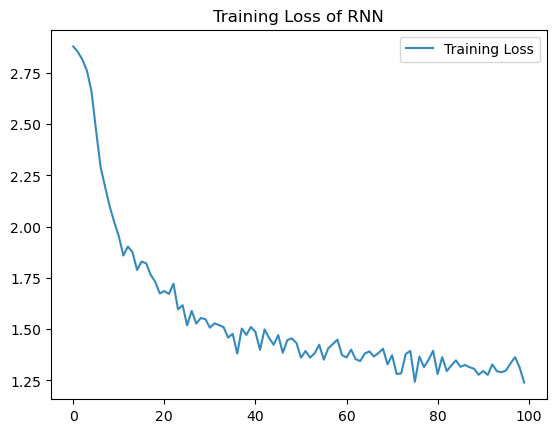

In [ ]:
plt.figure()
plt.plot(all_losses, label="Training Loss")
plt.title("Training Loss of RNN")
plt.legend()
plt.show()

/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/3167032125.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/3167032125.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


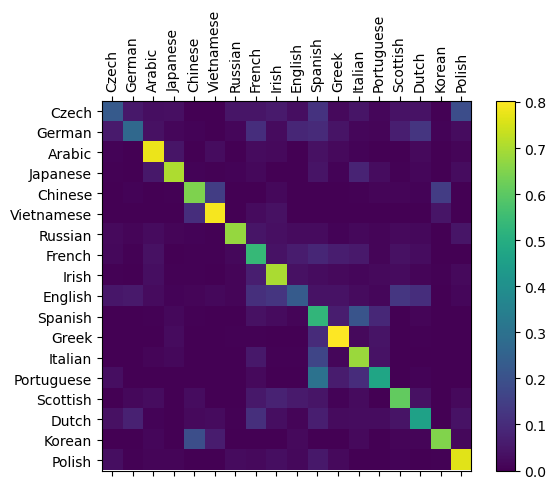

In [ ]:
confusionmatrix, all_categories = confusionMatrix(rnn, n_categories, all_categories, all_letters, n_letters)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusionmatrix)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### GRU

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.candidate = nn.Linear(input_size + hidden_size, hidden_size)
        self.update_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.reset_gate = nn.Linear(input_size + hidden_size, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        update = torch.sigmoid(self.update_gate(combined))
        reset = torch.sigmoid(self.reset_gate(combined))

        combined = torch.cat((input, reset * hidden), 1)
        candidate = torch.tanh(self.candidate(combined))

        hidden = (1 - update) * hidden + update * candidate

        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
gru = GRU(n_letters, n_hidden, n_categories)

In [ ]:
gru, all_losses = trainModel(gru, all_categories, all_letters, n_letters)

5000 5% (0m 5s) 2.9423 Trieu / Chinese ✗ (Vietnamese)
10000 10% (0m 11s) 2.8706 Van / Chinese ✗ (Vietnamese)
15000 15% (0m 16s) 2.6830 Abello / Portuguese ✗ (Spanish)
20000 20% (0m 22s) 2.7448 Tikal / Japanese ✗ (Czech)
25000 25% (0m 27s) 1.7590 Martinelli / Italian ✓
30000 30% (0m 33s) 2.0239 Araya / Japanese ✗ (Spanish)
35000 35% (0m 38s) 0.9805 Yau / Chinese ✓
40000 40% (0m 44s) 1.5615 Forest / French ✓
45000 45% (0m 50s) 0.8339 Kouros / Greek ✓
50000 50% (0m 55s) 0.9546 Anderson / Scottish ✓
55000 55% (1m 1s) 1.2257 Zhen / Vietnamese ✗ (Chinese)
60000 60% (1m 6s) 1.4553 Chlebek / Czech ✗ (Polish)
65000 65% (1m 12s) 1.1747 Bitar / Arabic ✓
70000 70% (1m 18s) 0.8324 Dai / Chinese ✓
75000 75% (1m 23s) 2.0856 Houttum / Arabic ✗ (Dutch)
80000 80% (1m 29s) 0.0342 Shahnazarov / Russian ✓
85000 85% (1m 34s) 1.0989 Aiza / Spanish ✓
90000 90% (1m 40s) 1.0457 Rooijakker / Dutch ✓
95000 95% (1m 45s) 1.0171 Phi / Vietnamese ✓
100000 100% (1m 51s) 1.2486 Seelenfreund / French ✗ (German)


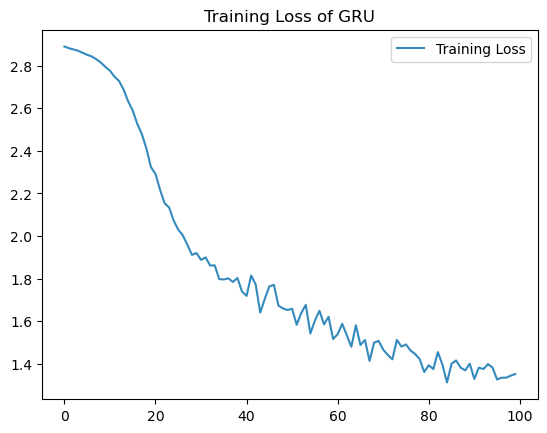

In [ ]:
plt.figure()
plt.plot(all_losses, label="Training Loss")
plt.title("Training Loss of GRU")
plt.legend()
plt.show()

/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/3485923907.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/3485923907.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


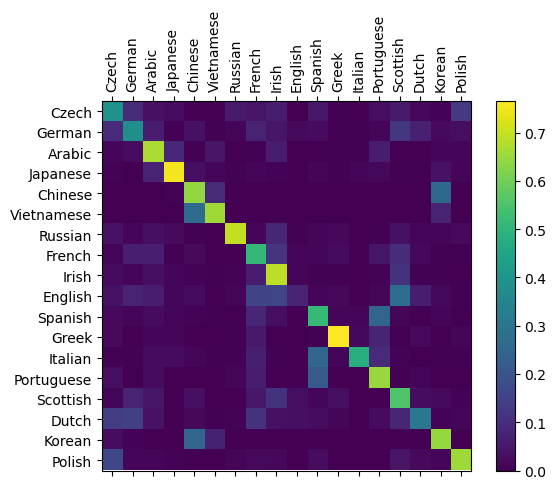

In [ ]:
confusionmatrix, all_categories = confusionMatrix(gru, n_categories, all_categories, all_letters, n_letters)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusionmatrix)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.candidate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        cell_state, hidden = hidden

        combined = torch.cat((input, hidden), 1)
        input_gate = torch.sigmoid(self.input_gate(combined))
        forget_gate = torch.sigmoid(self.forget_gate(combined))
        output_gate = torch.sigmoid(self.output_gate(combined))
        candidate = torch.tanh(self.candidate(combined))

        cell_state = forget_gate * cell_state + input_gate * candidate
        hidden = output_gate * torch.tanh(cell_state)

        output = self.h2o(hidden)
        output = self.softmax(output)

        return output, (cell_state, hidden)

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)

In [ ]:
lstm, all_losses = trainModel(lstm, all_categories, all_letters, n_letters)

5000 5% (0m 6s) 2.8621 Faerber / French ✗ (German)
10000 10% (0m 13s) 2.8114 Drozdovsky / Irish ✗ (Russian)
15000 15% (0m 19s) 2.9173 Ly / Arabic ✗ (Vietnamese)
20000 20% (0m 26s) 2.8277 Hajjar / Japanese ✗ (Arabic)
25000 25% (0m 33s) 2.7197 Leeuwenhoek / Czech ✗ (Dutch)
30000 30% (0m 39s) 2.7682 Solomon / Irish ✗ (French)
35000 35% (0m 46s) 2.3924 Funabashi / Polish ✗ (Japanese)
40000 40% (0m 52s) 2.6894 Baroch / Irish ✗ (Czech)
45000 45% (0m 59s) 1.5090 Innocenti / Italian ✓
50000 50% (1m 5s) 1.7845 Gouveia / Portuguese ✓
55000 55% (1m 12s) 2.4052 Snelker / German ✗ (Czech)
60000 60% (1m 18s) 1.0795 Crespo / Portuguese ✓
65000 65% (1m 24s) 0.3640 Kreskas / Greek ✓
70000 70% (1m 31s) 1.4830 Schuler / German ✓
75000 75% (1m 37s) 4.0566 Clark / Czech ✗ (Irish)
80000 80% (1m 44s) 2.9408 Fenwick / Polish ✗ (English)
85000 85% (1m 50s) 0.9831 Fan / Chinese ✓
90000 90% (1m 57s) 1.6639 Ritchie / Scottish ✓
95000 95% (2m 3s) 3.1129 Gehrig / Vietnamese ✗ (German)
100000 100% (2m 10s) 0.7563 Ph

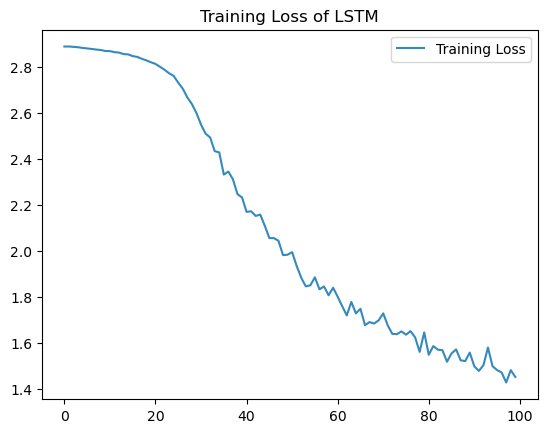

In [ ]:
plt.figure()
plt.plot(all_losses, label="Training Loss")
plt.title("Training Loss of LSTM")
plt.legend()
plt.show()

/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/1024933662.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/8p/r8s74_1j3fl8lkd05zby5sjw0000gn/T/ipykernel_83071/1024933662.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


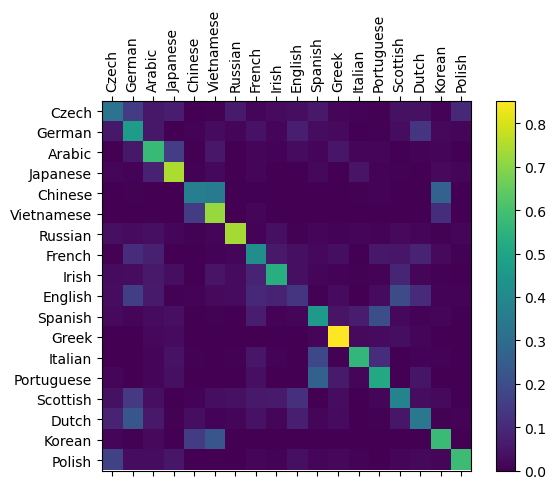

In [ ]:
confusionmatrix, all_categories = confusionMatrix(lstm, n_categories, all_categories, all_letters, n_letters)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusionmatrix)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()